# Chapter 6: Delivery to Client

#### From Stephen Klosterman's book DATA SCIENCE PROJECTS WITH PYTHON (2019).

<h3>Goals:</h3>
<ul>
    <li>Compare the results of all models built for a case study</li>
    <li>Replace missing data using a range of imputation strategies</li>
    <li>Build a multiclass classification model</li>
    <li>Conduct financial analysis to find the optimal threshold for binary classification</li>
    <li>Derive financial insight from the model to help the client guide budgeting and operational strategy</li>
    <li>Deliver the model and make recommendations for usage</li>
</ul>

In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn
print('The Python version is {}.\n'.format(sys.version))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))

The Python version is 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)].

The Scikit-Learn version is 0.22.1.



In [2]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 

#Next line helps with rendering plots
%matplotlib inline

mpl.rcParams['figure.dpi'] = 100

## Exercise 22: Cleaning the Dataset

In [3]:
df_orig = pd.read_excel('Data/default_of_credit_card_clients__courseware_version_1_21_19.xls')

#### Make a Boolean array indicating where the entries of the Dataframe are equal to 0

In [4]:
df_zero_mask = (df_orig == 0)

#### Collapse this 2-dimensional Boolean array to 1 dimension by indicating which rows have 0s in all columns, starting with the second column. This array tells which rows have a value of 0 for all the features and need to be removed.

In [5]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
sum(feature_zero_mask)

315

#### Use this mask to select all the rows that don't have values of zero for all features, and check the shape of the resulting DataFrame

In [6]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
print(df_clean.shape)
print(df_clean['ID'].nunique())

(29685, 25)
29685


#### Replace the undocumented values for EDUCATION and MARRIAGE features with the documented values for "unknown".

#### "Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)"
#### "Marriage (1 = married; 2 = single; 3 = others)."

In [7]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)

In [8]:
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)

#### The missing values in PAY_1 are indicated by the string "Not available"

In [9]:
df_clean['PAY_1'].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [11]:
missing_pay_1_mask = (df_clean['PAY_1'] == 'Not available')
sum(missing_pay_1_mask)

3021

In [12]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()
print(df_missing_pay_1.shape)
print(df_missing_pay_1.columns)
df_missing_pay_1['PAY_1'].value_counts()

(3021, 25)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


Not available    3021
Name: PAY_1, dtype: int64

#### Load cleaned data

In [14]:
df = pd.read_csv('Data/Chapter_1_cleaned_data_OLD.csv')
print(df.columns)
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
features_response

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'none', 'others', 'university'],
      dtype='object')


['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

## Exercise 23: Mode and Random Imputation of `PAY_1`

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features_response[:-1]].values, 
    df['default payment next month'].values,
    test_size=0.2, 
    random_state=24)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


#### Confirm the index of PAY_1

In [16]:
features_response[4]

'PAY_1'

#### Check the median of PAY_1

In [17]:
np.median(X_train[:,4])

0.0

<p>Recall that the the mode of non-missing PAY_1 is also 0.</p>

<p>Since the median and the mode are the same, we only have two imputation strategies to test in this exercise: the mode/median and a random selection of non-missing.</p>

#### Create a list of values for imputation

In [19]:
np.random.seed(seed=1)

fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

fill_strategy = ['mode', 'random']

fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)

#### Use histograms to examine the distributions of the original non-missing PAY_1 feature in the training sent and the randomly selected imputed values

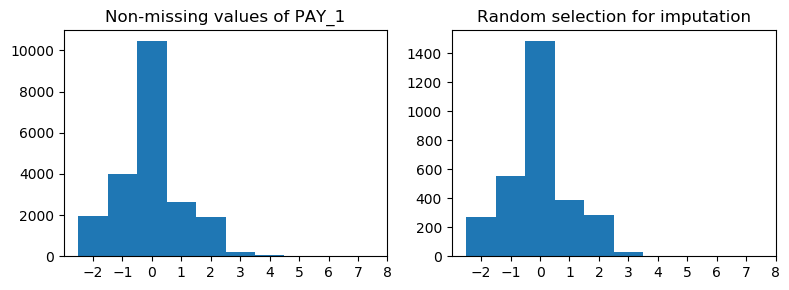

In [20]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

<p>The two distributions look very similar. Only the scale of the y-axis indicates that there are fewer imputed values than in the original dataset. This shows that we have selected values for <strong>PAY_1</strong> that faithfully imitate the relative frequency of different values of this feature in the data.</p>

#### We do not need to do a cross-validation search for hyperparameters here, as at this point we already know that random forest is the model we will use, and we know what hyperparameters we should use.
#### We just want to perform cross-validation with one set of hyperparameters in order to have several estimates of the out-of-sample testing score.

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

rf = RandomForestClassifier\
(n_estimators=200, criterion='gini', max_depth=9,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=1, warm_start=False, class_weight=None)

for counter in range(len(fill_values)):
    #Copy the data frame with missing PAY_1 and assign imputed values
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    
    #Split imputed data in to training and testing, using the same
    #80/20 split we have used for the data with non-missing PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(
        df_fill_pay_1_filled[features_response[:-1]].values,
        df_fill_pay_1_filled['default payment next month'].values,
    test_size=0.2, random_state=24)
    
    #Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    
    #Use the KFolds splitter and the random forest model to get
    #4-fold cross-validation scores for both imputation methods
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')
    
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737
random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.9s finished


## A Predictive Model for `PAY_1`

In [24]:
pay_1_df = df.copy()
features_for_imputation = pay_1_df.columns.tolist()
items_to_remove_2 = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove_2]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

## Exercise 24: Building a Multiclass Classification Model for Imputation

In [28]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
    test_size=0.2, 
    random_state=24)

rf_impute_params = {'max_depth':[3, 6, 9, 12],
                    'n_estimators':[10, 50, 100, 200]}

#### Need to use accuracy here as ROC AUC is not supported for multiclass. Need to use multiclass and not regression because need to limit to integer values of `PAY_1`.

In [29]:
from sklearn.model_selection import GridSearchCV

cv_rf_impute = GridSearchCV(
    rf, 
    param_grid=rf_impute_params, 
    scoring='accuracy',
    n_jobs=-1, 
    refit=True,
    cv=4, 
    verbose=2, 
    error_score=np.nan, 
    return_train_score=True)

cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   35.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.7s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=9,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=4,
                                      

In [30]:
impute_df = pd.DataFrame(cv_rf_impute.cv_results_)
impute_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.185516,0.006168,0.015210,0.004591,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.664729,0.669417,0.671479,0.664291,0.667479,0.003061,15,0.669396,0.670146,0.665146,0.670042,0.668682,0.002062
1,0.884828,0.012083,0.042886,0.003926,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.657979,0.660229,0.660604,0.651350,0.657540,0.003712,16,0.664521,0.657145,0.654082,0.660854,0.659150,0.003920
2,1.770586,0.014617,0.099000,0.008385,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.672605,0.673542,0.675792,0.667854,0.672448,0.002894,13,0.677835,0.675147,0.670521,0.676167,0.674918,0.002713
3,3.590165,0.033823,0.154666,0.007872,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.664917,0.666042,0.675792,0.666354,0.668276,0.004372,14,0.672334,0.668896,0.669021,0.672605,0.670714,0.001758
4,0.291327,0.003297,0.013247,0.002382,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.710294,0.706919,0.713482,0.700675,0.707843,0.004744,12,0.717027,0.717027,0.718465,0.711607,0.716032,0.002621


In [31]:
print(cv_rf_impute.best_params_)
print(cv_rf_impute.best_score_)

{'max_depth': 12, 'n_estimators': 200}
0.7344242187492307


In [32]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts/pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

#### To check that cross-validation accuracy generalizes to the test set, we need to make predictions on the test set

In [34]:
from sklearn import metrics

y_impute_predict = cv_rf_impute.predict(X_impute_test)

metrics.accuracy_score(y_impute_test, y_impute_predict)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.7391711981998875

### Plot actual values and predictions for the hold-out test set

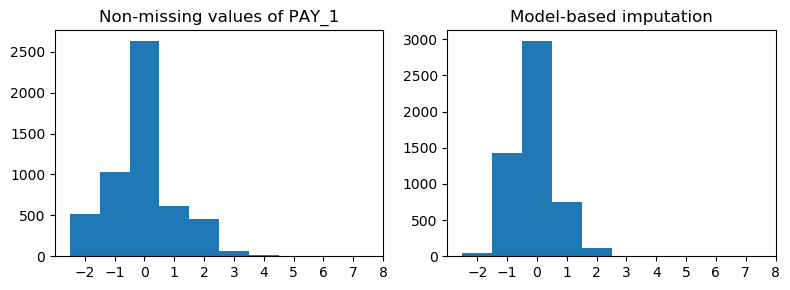

In [35]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

<p>The figures show that the imputation model is more likely to predict a value of 0 for <strong>PAY_1</strong> than it should be. However, it does predict other values and consequently is more accurate than the mode imputation.</p>

<p>So our imputation model has been tested and the selected hyperparameters are confirmed. After the hold-out test set has been used to check model performance on unseen data, all the training and testing dasta should be put together, to train a model on as much data as possible.</p> 

<p>Increasing the amount of training typically results in a better model.</p>

In [37]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

rf_impute

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Using the Imputation Model and Comparing it to Other Methods

In [40]:
df_fill_pay_1_model = df_missing_pay_1.copy()
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      30
-1     763
 0    1715
 1     438
 2      64
 3       7
 4       2
 6       1
 8       1
Name: PAY_1, dtype: int64

#### Split the model-imputed data

In [41]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

print(X_fill_pay_1_train.shape)
print(X_fill_pay_1_test.shape)
print(y_fill_pay_1_train.shape)
print(y_fill_pay_1_test.shape)

(2416, 17)
(605, 17)
(2416,)
(605,)


#### Combine this with the data with known PAY_1 as before

In [42]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

print(X_train_all.shape)
print(y_train_all.shape)

(23747, 17)
(23747,)


#### Confirm that the rf object still holds the model with optimal hyperparameters for the case study problem

In [43]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=4, verbose=1,
                       warm_start=False)

<p>The <strong>rf</strong> object holds a random forest classifier with 200 trees and maximum depth of 0, as expected.</p>

#### Now, use this model with the combined imputed and non-missing training data in cross-validation as we did with the other imputation methods, to test model-imputation

In [44]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.6s finished


#### Examine the average model testing score across the four folds

In [45]:
imputation_compare_cv['test_score']

array([0.76890992, 0.77309591, 0.77166336, 0.77703366])

In [46]:
np.mean(imputation_compare_cv['test_score'])

0.7726757126815554

In [47]:
np.std(imputation_compare_cv['test_score'])

0.002931480680760725

#### Reassign values using mode imputation

In [48]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

print(X_train_all.shape)
print(X_test_all.shape)
print(y_train_all.shape)
print(y_test_all.shape)

(23747, 17)
(5938, 17)
(23747,)
(5938,)


In [49]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')

np.mean(imputation_compare_cv['test_score'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.5s finished


0.772866246168149

## Confirming Model Performance on the Unseen Test Set

<p>We are nearly done building the model for the case study data. The final step in the model building process is to examine model performance on the test set, which we have reserved from using for any model-building activities up till now.</p>

#### Now that we have assembled all the non-imputed and imputed data for training and testing, we can train the final model

In [50]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=4, verbose=1,
                       warm_start=False)

#### Finally, we make predictions for credit default on the testing set. We need to predict probabilities so we can calculate ROC AUC

In [51]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

0.7696243835824927

## Exercise 25: Characterizing Costs and Savings

#### Create a range of thresholds to calcualte expected costs and benefits of counseling

In [53]:
# 101 linearly spaced points between 0 and 1, inclusive
thresholds = np.linspace(0, 1, 101)

#### Confirm the index of the testing data features array that corresponds to the most recent month's bill

In [54]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

#### Capture the bill amount as the potential savings per default and observe it

In [55]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

51601.7433479286

#### Store the cost of counseling and effectiveness in variables to use for analysis

In [56]:
cost_per_counseling = 7500
effectiveness = 0.70

#### Now, we will calculate costs and savings for each of the thresholds.

In [57]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)

counter = 0
for threshold in thresholds:
    pos_pred = y_test_all_predict_proba[:,1]>threshold
    n_pos_pred[counter] = sum(pos_pred)
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
    
    counter += 1
    
net_savings = savings_of_all_counselings - cost_of_all_counselings

#### Plot the net savings against the thresholds

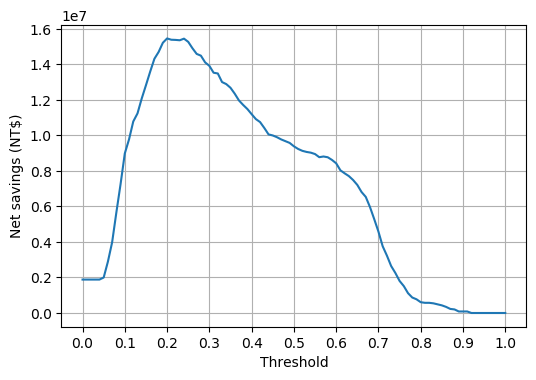

In [59]:
mpl.rcParams['figure.dpi'] = 100
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

#### Display the threshold that results in the greatest net savings

In [60]:
max_savings_ix = np.argmax(net_savings)

print(thresholds[max_savings_ix])

print(net_savings[max_savings_ix])

0.2
15446325.35991916
